In [1]:
%matplotlib inline  
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random

import cPickle

import os
from scipy.io import loadmat

#Load the MNIST digit data
M = loadmat("mnist_all.mat")

#Display the 150-th "5" digit from the training set
#imshow(M["train5"][150].reshape((28,28)), cmap=cm.gray)
#show()


def softmax(y):
    '''Return the output of the softmax function for the matrix of output y. y
    is an NxM matrix where N is the number of outputs for a single case, and M
    is the number of cases'''
    return exp(y) / tile(sum(exp(y), 0), (len(y), 1))


def tanh_layer(y, W, b):
    '''Return the output of a tanh layer for the input matrix y. y
    is an NxM matrix where N is the number of inputs for a single case, and M
    is the number of cases'''
    return tanh(dot(W.T, y) + b)


def forward(x, W0, b0, W1, b1):
    L0 = tanh_layer(x, W0, b0)
    L1 = dot(W1.T, L0) + b1
    output = softmax(L1)
    return L0, L1, output

def deriv_multilayer(W0, b0, W1, b1, x, L0, L1, y, y_):
    dCdL1 = y - y_
    dCdW1 = dot(L0, dCdL1.T)
    dCdobydodh = dot(W1, dCdL1)
    one_minus_h_sq = 1 - L0**2

    dCdW0 = tile(dCdobydodh, 28 * 28).T * dot(x, (one_minus_h_sq.T))
    dCdb1 = dCdL1
    dCdb0 = dCdobydodh * one_minus_h_sq

    return dCdW1, dCdb1, dCdW0, dCdb0

In [2]:
def cross_entropy(y, y_):
    return -sum(y_ * log(y))

In [3]:
#Load sample weights for the multilayer neural network
f = open("snapshot50.pkl", "rb")
snapshot = cPickle.load(f)
W0 = snapshot["W0"]
b0 = snapshot["b0"].reshape((300, 1))
W1 = snapshot["W1"]
b1 = snapshot["b1"].reshape((10, 1))

# L0, L1, output = forward(x, W0, b0, W1, b1)
# y = argmax(output)

# y_true = array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]]).T
# print(deriv_multilayer(W0, b0, W1, b1,x, L0, L1, output, y_true))
################################################################################
# Code for displaying a feature from the weight matrix mW
# fig = figure(1)
# ax = fig.gca()
# heatmap = ax.imshow(W0[:, 50].reshape((28, 28)), cmap=cm.coolwarm)
# fig.colorbar(heatmap, shrink=0.5, aspect=5)
# show()
################################################################################

In [32]:
def get_batch(offset,example_per_class=5):
    # 5 examples per class
    classes_num = 10
    x_batch = np.zeros((example_per_class * classes_num, 28 * 28))
    y_batch = np.zeros((example_per_class * classes_num, classes_num))
    for i in xrange(classes_num):
        for j in xrange(example_per_class):
            x_batch[i * example_per_class + j] = M['train' + str(i)][j +
                                                                     offset]
            y_batch[i * example_per_class + j][i] = 1
    return x_batch, y_batch, example_per_class * classes_num

In [7]:
#Load one example from the training set, and run it through the
def test_image(x):
    _,_, output = forward(x, W0, b0, W1, b1)
    return argmax(output)

def test_perf():
    hit = miss = 0
    for i in range(10):
        for image in M["test" + str(i)]:
            result = test_image(image.reshape(784,1))
            if result == i:
                hit+=1
            else:
                miss+=1
    return (float(hit)/float(hit + miss) * 100)
test_perf()

41.54

In [8]:
# Do gradient descent
plot_iters = []
plot_performance = []
def train(plot=False):
    global W0, b0, W1, b1
    global plot_iters, plot_performance
    alpha = 1e-3
    for i in xrange(50):
        X, Y, examples_n = get_batch(i * 5)

        update = np.zeros(4)

        for j in xrange(examples_n):
            y = Y[j].reshape((10, 1))
            x = X[j].reshape((28 * 28, 1))
            L0, L1, output = forward(x, W0, b0, W1, b1)
            gradients = deriv_multilayer(W0, b0, W1, b1, x, L0, L1, output, y)
            update = [update[k] + gradients[k] for k in range(len(gradients))]

        # update the weights 
        W1 -= alpha * update[0]
        b1 -= alpha * update[1]
        W0 -= alpha * update[2]
        b0 -= alpha * update[3]
        if plot:
            plot_iters.append(i * examples_n)
            plot_performance.append(test_perf())
            
train(plot=True)

[0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600, 1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150, 2200, 2250, 2300, 2350, 2400, 2450]
[55.06999999999999, 57.730000000000004, 66.17, 67.27, 69.37, 70.46, 71.69, 69.81, 70.63000000000001, 72.63, 72.46000000000001, 71.09, 71.84, 75.08, 74.7, 73.02, 73.45, 75.64999999999999, 75.48, 73.19, 76.32, 76.13, 77.8, 74.41, 77.29, 76.29, 76.35, 78.01, 78.53, 78.85, 79.28, 78.71000000000001, 79.16, 79.67999999999999, 77.17, 79.73, 79.86, 80.24, 81.01, 80.92, 80.36, 81.54, 81.34, 80.12, 80.87, 81.77, 81.13, 81.47999999999999, 81.17, 80.15]


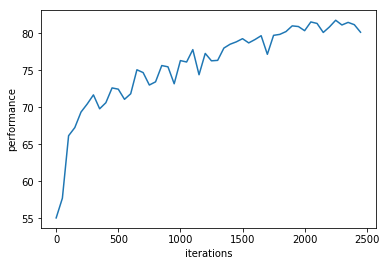

In [9]:
# print(plot_iters)
# print(plot_performance)

plt.figure()
plt.plot(plot_iters,plot_performance)
plt.ylabel('performance')
plt.xlabel('iterations')
plt.savefig("images/performance.png")

In [75]:
def grad_descent(f, df, x, y, init_t, alpha):
    EPS = 1e-5
    prev_t = init_t-10*EPS
    t = init_t.copy()
    max_iter = 30000
    iter  = 0
    while iter < max_iter:
        prev_t = t.copy()
        t -= alpha*df(x, y, t)
        if iter % 500 == 0:
            print "Iter", iter
#             print "f(x) = {}".format(t[0], t[1], t[2], f(x, y, t))
#             print "Gradient: ", df(x, y, t), "\n"
        iter += 1
    return t

def test_performance_linear(theta):
    hit = miss = 0
    for i in range(10):
        for image in M["test" + str(i)]:
            result = np.dot(np.append(ones(1),image),theta.T)
            if result.argmax() == i:
                hit+=1
            else:
                miss+=1
    return (float(hit)/float(hit + miss) * 100)
# test_perf()

In [84]:
def f(x, y, theta,bias=True):
    if bias:
        x = hstack((ones((x.shape[0],1)), x))
    return sum(sum((y - dot(x,theta.T)) ** 2))


def df(x, y, theta,bias=True):
    if bias:
        x = hstack( (ones((x.shape[0],1)), x))
    return 2 * dot((dot(x,theta.T) - y).T,x)

X,Y,n = get_batch(0,150)
X = X/255.
theta0 = np.zeros(10 * 785)
theta0 = theta0.reshape(10,785)
theta = grad_descent(f, df, X, Y, theta0, 1e-9)

Iter 0
Iter 500


KeyboardInterrupt: 

In [82]:
test_performance_linear(theta)

64.3